Group 26 Project 2
Jodi Barnes
Lauren Moffett


In [19]:
# Imports

import numpy as np 
import os 
import pandas as pd 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt 

RANDOM_STATE = 42

# Paths

TRAIN_PATH = "project_adult.csv"
VAL_INPUTS_PATH = "project_validation_inputs.csv"
PRED_OUT_PATH = "Group_26_MLP_PredictedOutputs.csv"


In [20]:
# Training data prep

df = pd.read_csv(TRAIN_PATH) # Pulls in UCI Adult Income

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].replace('?', 'unknown') # Replacing the ? with unknown, like we did in our first project

target_col = 'income' if 'income' in df.columns else df.columns[-1] # Choose target column, default if needed
y_raw = df[target_col].astype(str)
X_raw = df.drop(columns=[target_col])

# Separates the numeric and categorical columns
num_cols = X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object']).columns.tolist()

In [21]:
# Preprocess Transformer

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), num_cols), # Scaling helps the MLP optimization
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), cat_cols),
    ],
    remainder='drop'
)
# Because adult has miuxed types categorical has to be one hot encoded
# Handle_unknown='ignore' makes sure the validation inputs won't creash when they have unseen categories

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_raw, test_size=0.2, random_state=RANDOM_STATE, stratify=y_raw
)

In [22]:
# Baseline Model

baseline = Pipeline(steps=[  # Guarentees identical preprocessing at train/test/inference
    ('prep', preprocess),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(50,),  # Single hidden layer baseline connects to MLP definition 
        activation='relu',  # Recommended for hidden layers
        solver='adam',
        learning_rate_init=0.001,
        early_stopping=True,  
        validation_fraction=0.1,
        n_iter_no_change=10,
        max_iter=500,
        random_state=RANDOM_STATE
    ))
])

baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)

base_acc = accuracy_score(y_test, y_pred_base)
print("Baseline accuracy:", base_acc)
print(classification_report(y_test, y_pred_base))

Baseline accuracy: 0.8500959692898272
              precision    recall  f1-score   support

       <=50K       0.87      0.94      0.90      3956
        >50K       0.74      0.57      0.65      1254

    accuracy                           0.85      5210
   macro avg       0.81      0.76      0.78      5210
weighted avg       0.84      0.85      0.84      5210



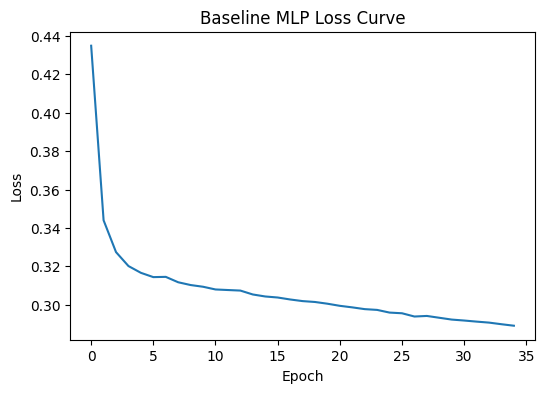

In [23]:
# Loss Plot Helper

def plot_loss_curve(fitted_pipeline, title="Loss Curve"):
    clf = fitted_pipeline.named_steps['clf']
    if hasattr(clf, 'loss_curve_'):
        plt.figure(figsize=(6,4))
        plt.plot(clf.loss_curve_)
        plt.title(title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

plot_loss_curve(baseline, title="Baseline MLP Loss Curve")

In [24]:
# Build and compare multiple candidate MLPs
candidates = [
    dict(hidden_layer_sizes=(32,),  activation='relu',    solver='adam', lr=0.001),
    dict(hidden_layer_sizes=(64,),  activation='relu',    solver='adam', lr=0.001),
    dict(hidden_layer_sizes=(128,), activation='relu',    solver='adam', lr=0.001),
    dict(hidden_layer_sizes=(64,32),activation='relu',    solver='adam', lr=0.001),
    dict(hidden_layer_sizes=(64,32),activation='tanh',    solver='adam', lr=0.001),
    dict(hidden_layer_sizes=(64,),  activation='relu',    solver='sgd',  lr=0.01),
    dict(hidden_layer_sizes=(100,), activation='logistic',solver='adam', lr=0.001),
]

results = []
best_model = None
best_acc = -np.inf

for cfg in candidates: # Iterate over candidate configs
    model = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', MLPClassifier(
            hidden_layer_sizes=cfg['hidden_layer_sizes'],
            activation=cfg['activation'],
            solver=cfg['solver'],
            learning_rate_init=cfg['lr'],
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=15,
            max_iter=600,
            random_state=RANDOM_STATE
        ))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    p, r, f, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

    results.append({
        "hidden_layer_sizes": cfg['hidden_layer_sizes'],
        "activation": cfg['activation'],
        "solver": cfg['solver'],
        "lr": cfg['lr'],
        "accuracy": acc,
        "precision_w": p,
        "recall_w": r,
        "f1_w": f,
        "model": model
    })

    if acc > best_acc: # Update best tracker if improved
        best_acc = acc
        best_model = model

# Quick leaderboard
for row in sorted(results, key=lambda d: d["accuracy"], reverse=True)[:5]:
    print(row["hidden_layer_sizes"], row["activation"], row["solver"], row["lr"], "->", round(row["accuracy"], 4))
print("BEST ACCURACY:", round(best_acc, 4))

(32,) relu adam 0.001 -> 0.8503
(100,) logistic adam 0.001 -> 0.8489
(128,) relu adam 0.001 -> 0.8482
(64,) relu sgd 0.01 -> 0.8482
(64, 32) tanh adam 0.001 -> 0.8468
BEST ACCURACY: 0.8503


Best params: {'clf__activation': 'tanh', 'clf__hidden_layer_sizes': (64, 32), 'clf__learning_rate_init': 0.01, 'clf__solver': 'adam'}
Best CV accuracy: 0.8541
Test accuracy: 0.8505


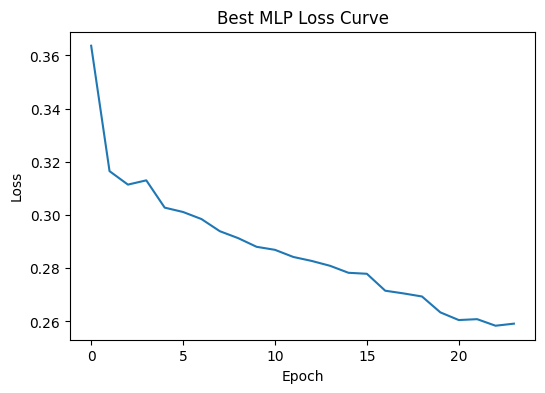

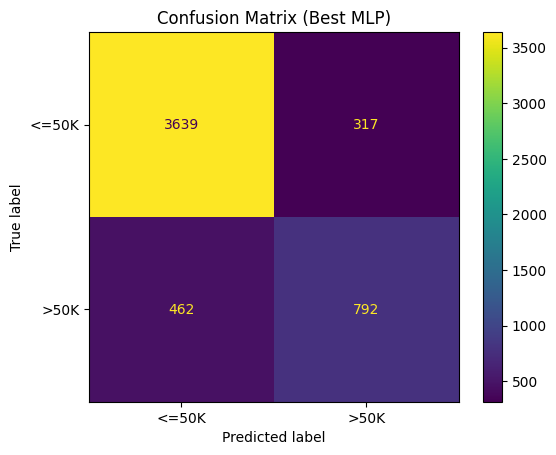

In [25]:
# Grid search: compact MLP sweep
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(50,),
        activation='relu',
        solver='adam',
        learning_rate_init=0.001,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=15,
        max_iter=600,
        random_state=RANDOM_STATE
    ))
])

param_grid = {
    'clf__hidden_layer_sizes': [(32,), (64,), (64, 32)],
    'clf__activation': ['relu', 'tanh'],
    'clf__solver': ['adam'],
    'clf__learning_rate_init': [0.001, 0.01],
}

grid = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, refit=True)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Best params:', grid.best_params_)
print('Best CV accuracy:', round(grid.best_score_, 4))
print('Test accuracy:', round(acc, 4))

plot_loss_curve(best_model, title="Best MLP Loss Curve")

from sklearn.metrics import ConfusionMatrixDisplay
y_best = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_)
disp.plot(values_format='d')
plt.title("Confusion Matrix (Best MLP)")
plt.show()

In [26]:
# Validation inference

val_df = pd.read_csv(VAL_INPUTS_PATH)

for col in val_df.select_dtypes(include=['object']).columns: # Iterate string columns
    val_df[col] = val_df[col].replace('?', 'unknown')

val_pred_str = best_model.predict(val_df)

val_pred_out = np.where(val_pred_str.astype(str) == '>50K', 1, -1)

pd.DataFrame(val_pred_out, columns=['prediction']).to_csv(PRED_OUT_PATH, index=False)
print("Wrote:", PRED_OUT_PATH, "shape:", val_pred_out.shape)

Wrote: Group_26_MLP_PredictedOutputs.csv shape: (6513,)


## Part 2
# Why did we choose this specific architecture
We compared several small MLPs and selected the one with the best cross-validated accuracy using a compact GridSearchCV sweep. Two modest hidden layers (e.g., (64, 32)) with ReLU balanced capacity and generalization — enough to learn nonlinear interactions without overfitting. ReLU trains efficiently and avoids vanishing gradients; Adam with learning rates in {0.001, 0.01} converged reliably. Choices were guided by validation metrics and a smooth, decreasing loss curve.

# How did we monitor and mitigate overfitting in our models?
We mitigated overfitting with early stopping using a 10% validation split and a patience threshold, so training halted when validation loss stopped improving. We used 3-fold cross-validation in GridSearchCV to select hyperparameters that generalized beyond a single split, and we kept model capacity modest; the default L2 regularization (alpha) further acted as weight decay. By placing preprocessing inside the Pipeline, we avoided leakage because the scaler and encoder were fit only on training folds. Finally, we reserved a held-out test set for the end and reviewed the confusion matrix to check class-specific errors.

# What ethical concerns might arise from deploying models trained on these datasets?
The Adult Income dataset includes sensitive attributes (e.g., sex and race), so historical bias can produce disparate impact; we should evaluate subgroup metrics (such as precision/recall and equal opportunity) and consider debiasing if needed. Sensitive features should be avoided or carefully justified, with their effects documented. We should be transparent about the model’s purpose, limitations, and known biases, and we must protect personal data and comply with relevant regulations regarding consent and retention. Finally, performance and fairness should be monitored over time to detect and mitigate drift.

# Why are activation functions necessary in neural networks?
Activation functions provide nonlinearity. Without them, stacked linear layers collapse to a single linear map and cannot model complex relationships. Nonlinear activations enable universal function approximation. Practical choices like ReLU improve gradient flow and training speed compared with tanh/logistic, which can saturate.
